In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import numpy.ma as ma
from iris.util import broadcast_to_shape
from matplotlib.lines import Line2D

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining function to merge cube list into single large cube + add relaisation coord
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [4]:
#defining function to merge cube list into single large cube without adding realisation coord
def merge_cubes_again(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    for cube in cubes:
        new_cube = cube.copy()
        big_cube.append(new_cube)
    
    return big_cube.merge_cube()

In [5]:
#defining function to reset forecast reference time of cubes
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [6]:
#setting file path and ensemble codes
#ensembles grouped by season and QBO phase
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
coupled_jul_east = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw764','u-bw765'] 
coupled_jul_west = ['u-bw763','u-bw766','u-bw767'] 
coupled_jan_east = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca328']
coupled_jan_west = ['u-ca326', 'u-ca327', 'u-ca330','u-ca331']

In [7]:
#loading in ocean-land mask
my_mask = iris.load_cube('/shared/netscratch/lrm49/UKCA_VN112_TEST_SIMS/land_mask_bm249_da19910701_00.nc')[0,0]

#Setting zero values to true to mask ocean points
no_ocean = np.logical_not(my_mask.data)


/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'surface' invalid units u'level'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


In [8]:
#setting NH constraint between 40-75N
NH_constraint = iris.Constraint(latitude=lambda v: 40 <= v <= 75)

In [9]:
### EASTELRY ###

sat_east = iris.cube.CubeList()
for job_id in coupled_jul_east:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0] #loading in surface T
    sst_cube.data = ma.array(sst_cube.data, mask=broadcast_to_shape(no_ocean,sst_cube.shape,[1,2])) #masking ocean points
    sst_nh = sst_cube.extract(NH_constraint) #NH Constraint
    sst_cube_gm = area_average(sst_nh) #Taking area average
    time_limit = sst_cube_gm[6:120] #defining time to be from the point of eruption (July)

    sat_east.append(time_limit)
    
for job_id in coupled_jan_east:
    
    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]#loading in surface T
    sst_cube.data = ma.array(sst_cube.data, mask=broadcast_to_shape(no_ocean,sst_cube.shape,[1,2])) #masking ocean points
    sst_nh = sst_cube.extract(NH_constraint) #NH Constraint
    sst_cube_gm = area_average(sst_nh) #Taking area average
    time_limit = sst_cube_gm[0:114] #defining time to be from the point of eruption (Jan) 
    #and reducing to same length as July cubes so they can be merged 


    sat_east.append(time_limit)

In [10]:
### WESTERLY ###
sat_west = iris.cube.CubeList()
for job_id in coupled_jul_west:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0] #loading in surface T
    sst_cube.data = ma.array(sst_cube.data, mask=broadcast_to_shape(no_ocean,sst_cube.shape,[1,2])) #masking ocean points
    sst_nh = sst_cube.extract(NH_constraint) #NH Constraint
    sst_cube_gm = area_average(sst_nh) #Taking area average
    time_limit = sst_cube_gm[6:120] #defining time to be from the point of eruption (July)

    sat_west.append(time_limit)
    
for job_id in coupled_jan_west:
    
    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0] #loading in surface T
    sst_cube.data = ma.array(sst_cube.data, mask=broadcast_to_shape(no_ocean,sst_cube.shape,[1,2])) #masking ocean points
    sst_nh = sst_cube.extract(NH_constraint)#NH Constraint
    sst_cube_gm = area_average(sst_nh) #Taking area average
    time_limit = sst_cube_gm[0:114] #defining time to be from the point of eruption (Jan) 
    #and reducing to same length as July cubes so they can be merged 

    sat_west.append(time_limit)

In [11]:
### CONTROL ###
control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0] #loading in surface T
    sst_control.data = ma.array(sst_control.data, mask=broadcast_to_shape(no_ocean,sst_control.shape,[1,2])) #masking ocean points
    sst_nh = sst_control.extract(NH_constraint) #NH Constraint
    sst_control_gm = area_average(sst_nh)[0:114] #reducing to same length as July cubes so they can be compared 

    control.append(sst_control_gm)

In [12]:
#resetting cube times so they can be merged 
time_reset(sat_east)
time_reset(sat_west)
time_reset(control)

In [13]:
#merging into single cube
sat_merged_east = merge_cubes(sat_east)
sat_merged_west = merge_cubes(sat_west)
one_big_control = merge_cubes(control)

In [14]:
#Creating mean control 
mean_control = one_big_control.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [15]:
#Creating 10 year climatology
import iris.coord_categorisation
iris.coord_categorisation.add_month(mean_control,'time',name='month')
climatology_all_controls = mean_control.aggregated_by('month',iris.analysis.MEAN) 
climatology_long = np.tile(climatology_all_controls.data, 10)

climatology_short_1 = climatology_long[6:120]#for comparison with July ensembles
climatology_short_2 = climatology_long[0:114]#for comparison with Jan ensembles


In [16]:
### Easterly ###
anom_east = iris.cube.CubeList()

#calculating anomalies for july ensembles
for i in range(0,6):
    anomally_east = sat_merged_east[i] - climatology_short_1
    anom_east.append(anomally_east)

#calculating anomalies for jan ensembles
for i in range(6,11):
    anomally_east = sat_merged_east[i] - climatology_short_2
    anom_east.append(anomally_east)

In [17]:
### Westerly ###
anom_west = iris.cube.CubeList()

#calculating anomalies for july ensembles
for i in range(0,3):
    anomally_west = sat_merged_west[i] - climatology_short_1
    anom_west.append(anomally_west)

#calculating anomalies for jan ensembles
for i in range(3,7):
    anomally_west = sat_merged_west[i] - climatology_short_2
    anom_west.append(anomally_west)

In [18]:
#merging (again) into full E and W cubes
anom_east_full = merge_cubes_again(anom_east)
anom_west_full = merge_cubes_again(anom_west)

In [19]:
#Taking ensemble mean anomalies for East and West Phases
mean_anomally_east = anom_east_full.collapsed('realization',iris.analysis.MEAN)
mean_anomally_west = anom_west_full.collapsed('realization',iris.analysis.MEAN)

In [20]:
### Easterly ###
#Taking anomalies at 6 month intervals post-eruption
east_anomalies = []

start = mean_anomally_east[0]
anom_6_east = mean_anomally_east[6]
anom_12_east = mean_anomally_east[12]
anom_18_east = mean_anomally_east[18]
anom_24_east = mean_anomally_east[24]
anom_30_east = mean_anomally_east[30]


east_anomalies.append(start.data) 
east_anomalies.append(anom_6_east.data)
east_anomalies.append(anom_12_east.data)
east_anomalies.append(anom_18_east.data)
east_anomalies.append(anom_24_east.data)
east_anomalies.append(anom_30_east.data)

In [23]:
### Westerly ###
#Taking anomalies at 6 month intervals post-eruption
west_anomalies = []

start = mean_anomally_west[0]
anom_6_west = mean_anomally_west[6]
anom_12_west = mean_anomally_west[12]
anom_18_west = mean_anomally_west[18]
anom_24_west = mean_anomally_west[24]
anom_30_west = mean_anomally_west[30]

west_anomalies.append(start.data) 
west_anomalies.append(anom_6_west.data) 
west_anomalies.append(anom_12_west.data) 
west_anomalies.append(anom_18_west.data)
west_anomalies.append(anom_24_west.data) 
west_anomalies.append(anom_30_west.data)

In [24]:
#defining new time
time = range(0,120)

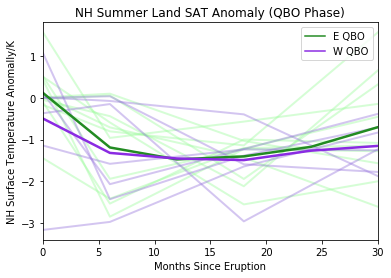

In [26]:
plt.figure(figsize=(6,4))

### PLOTTING EASTERLY ENSEMBLES ###

for cube in anom_east_full.slices_over('realization'): # loop through ensemble members
    east_anomalies_2 = []

    time_0 = cube[0]
    time_6 = cube[6]
    time_18 = cube[18]
    time_30 = cube[30]
   
    east_anomalies_2.append(time_0.data) 
    east_anomalies_2.append(time_6.data)
    east_anomalies_2.append(time_18.data)
    east_anomalies_2.append(time_30.data)
    
    plt.plot([time[0],time[6], time[18], time[30]], 
         east_anomalies_2, 
         color='palegreen', alpha = 0.4, lw=2)
    
### PLOTTING WESTERLY ENSEMBLES ###
    
for cube in anom_west_full.slices_over('realization'): # loop through ensemble members
    west_anomalies_2 = []

    time_0 = cube[0]
    time_6 = cube[6]
    time_18 = cube[18]
    time_30 = cube[30]
    
    west_anomalies_2.append(time_0.data) 
    west_anomalies_2.append(time_6.data) 
    west_anomalies_2.append(time_18.data)
    west_anomalies_2.append(time_30.data)
    
    plt.plot([time[0], time[6], time[18], time[30]], 
         west_anomalies_2, 
         color='mediumpurple', alpha = 0.4, lw=2) 


### PLOTTING ENSEMBLE MEANS ####

plt.plot([time[0], time[6], time[12], time[18], time[24], time[30]], 
         east_anomalies, color='forestgreen',lw=2.5)#plotting mean

plt.plot([time[0], time[6], time[12], time[18], time[24], time[30]], 
         west_anomalies, color='blueviolet',lw=2.5)#plotting mean

plt.xlim(time[0],time[30]) # plot only 5 years


plt.title('NH Summer Land SAT Anomaly (QBO Phase)')
plt.xlabel('Months Since Eruption')
plt.ylabel('NH Surface Temperature Anomally/K')
july_line = Line2D([0], [0], label='E QBO', color='forestgreen')
jan_line = Line2D([0], [0], label='W QBO', color='blueviolet')
plt.legend(handles=[july_line, jan_line], loc='upper right')

plt.savefig('SAT_by_QBO.pdf')

